Sedang mengunduh data BBRI.JK...


[*********************100%***********************]  1 of 1 completed

Data berhasil diambil: 703 hari perdagangan.


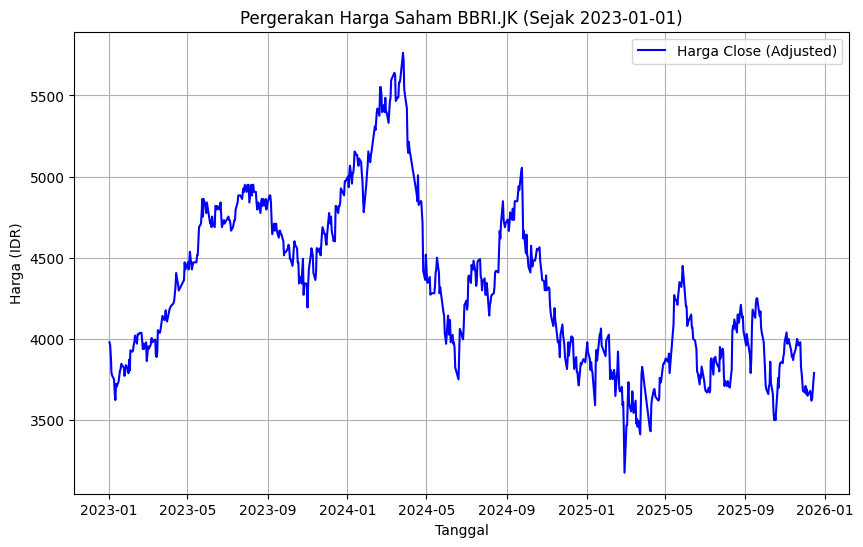


--- 5 Data Return Terakhir ---
Date
2025-12-09    0.002721
2025-12-10   -0.005450
2025-12-11   -0.010989
2025-12-12    0.002759
2025-12-15    0.043133
Name: Close, dtype: float64


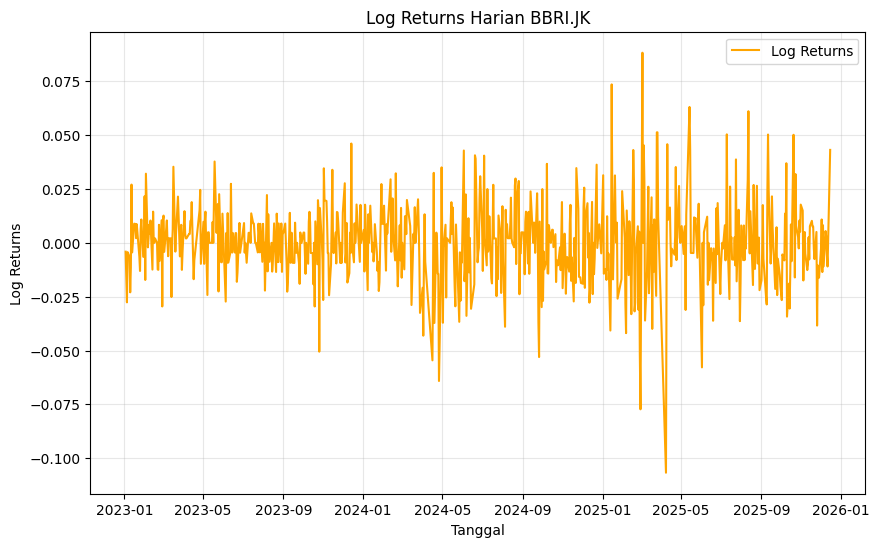


Volatilitas Harian BBRI.JK: 0.0187
(Artinya harga berubah sekitar 1.87% setiap harinya)

--- Tabel Hasil Simulasi (5 Baris Pertama) ---
            0            1            2            3            4   \
0  3790.000000  3790.000000  3790.000000  3790.000000  3790.000000   
1  3852.824181  3778.110556  3769.487894  3739.281395  3875.481019   
2  3883.944520  3757.952399  3696.231994  3642.335583  3698.746661   
3  3860.092904  3812.114280  3698.668721  3678.550446  3715.675745   
4  3790.590400  3871.300756  3686.768269  3696.124886  3759.437403   

            5            6            7            8            9   ...  \
0  3790.000000  3790.000000  3790.000000  3790.000000  3790.000000  ...   
1  3862.658326  3882.799593  3869.852856  3725.456921  3790.486129  ...   
2  3870.223239  4052.645326  3887.440513  3621.231359  3807.591320  ...   
3  3826.356308  4196.168425  3921.796704  3518.081058  3800.032644  ...   
4  3818.621415  4333.312639  3776.868625  3626.951855  3910.509642 

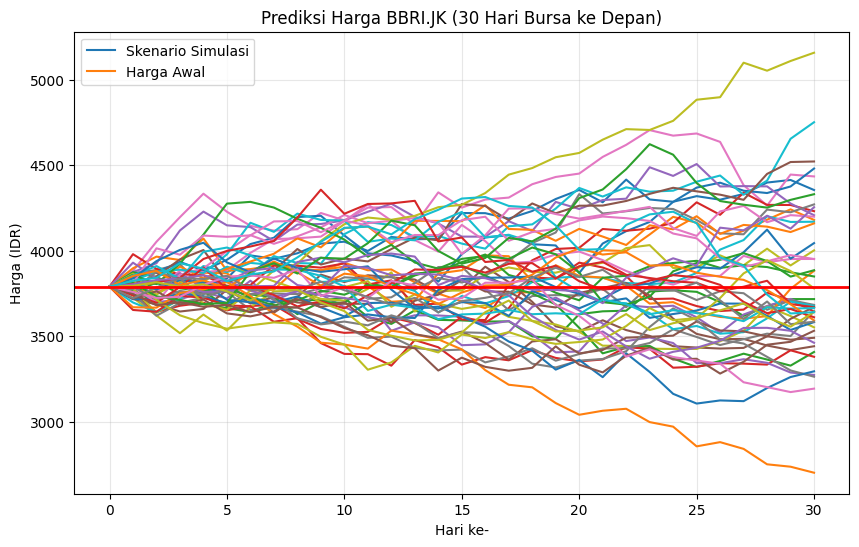


--- KESIMPULAN SIMULASI ---
Harga Terakhir (Real): Rp 3,790
Rata-rata Prediksi   : Rp 3,835
Peluang Harga Naik   : 44.00%


In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- BAGIAN 1: IMPORT DATA SAHAM BBRI ---
ticker = 'BBRI.JK'
start_date = '2023-01-01'  # Data dari awal 2023 sudah cukup representatif

def import_stock_data(ticker, start_date):
    # SARAN 1: Gunakan auto_adjust=True agar harga saham sudah disesuaikan (Adjusted Close)
    # Ini penting karena BBRI sering membagikan dividen & pernah stock split.
    # Jika tidak pakai ini, grafik harga bisa terlihat "anjlok" tiba-tiba saat stock split.
    data = yf.download(ticker, start=start_date, auto_adjust=True)
    
    # SARAN 2: Penanganan MultiIndex (Error yang sering terjadi di versi yfinance baru)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data

print(f"Sedang mengunduh data {ticker}...")
data = import_stock_data(ticker, start_date)

# Cek data kosong
if data.empty:
    print("PERINGATAN: Data tidak ditemukan. Cek koneksi internet atau ticker.")
else:
    print(f"Data berhasil diambil: {len(data)} hari perdagangan.")

# Output 1: Plot Harga Saham Historis
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Harga Close (Adjusted)', color='blue')
plt.title(f'Pergerakan Harga Saham {ticker} (Sejak {start_date})')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# --- BAGIAN 2: HITUNG LOG RETURNS ---
def log_returns(stock_data):
    # Menghitung return harian logaritmik
    # Dropna() penting untuk membuang baris pertama yang kosong (NaN)
    return np.log(1 + stock_data['Close'].pct_change()).dropna()

log_return = log_returns(data)

# Output 2: Print 5 Data Return Terakhir
print("\n--- 5 Data Return Terakhir ---")
print(log_return.tail())

# Output 3: Plot Log Return (Melihat volatilitas harian)
plt.figure(figsize=(10, 6))
plt.plot(log_return, label='Log Returns', color='orange')
plt.title(f'Log Returns Harian {ticker}')
plt.xlabel('Tanggal')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- BAGIAN 3: HITUNG VOLATILITAS (RISIKO) ---
def volatility_calc(lr):
    # Menghitung standar deviasi dari return
    return np.std(lr)

daily_vol = volatility_calc(log_return)

# Output 4: Print Volatilitas
print(f"\nVolatilitas Harian {ticker}: {daily_vol:.4f}")
print(f"(Artinya harga berubah sekitar {daily_vol*100:.2f}% setiap harinya)")

# --- BAGIAN 4: SIMULASI MONTE CARLO ---
# SARAN 3: Jumlah Simulasi
# Gunakan 50-100 simulasi saja untuk visualisasi grafik garis agar tidak terlalu 'semrawut'
# Tapi gunakan data statistik (mean) untuk kesimpulan akhir.
num_simulations = 50 
num_days = 30  # Prediksi 30 Hari Bursa ke depan
last_price = data['Close'].iloc[-1]

def run_monteCarlo(num_simulations, num_days, last_price, daily_vol):
    simulation_results = []
    
    for x in range(num_simulations):
        price_series = [last_price]
        
        for y in range(num_days):
            # Rumus Random Walk Sederhana:
            # Harga Besok = Harga Hari Ini * (1 + Kejutan Acak)
            # Kejutan Acak = Bilangan normal acak (mean=0, std=volatilitas harian)
            shock = np.random.normal(0, daily_vol)
            price = price_series[-1] * (1 + shock)
            price_series.append(price)
            
        simulation_results.append(price_series)
    
    # Transpose agar baris = hari, kolom = skenario simulasi
    return pd.DataFrame(simulation_results).T

simulation_df = run_monteCarlo(num_simulations, num_days, last_price, daily_vol)

# Output 5: Tabel Hasil Simulasi
print("\n--- Tabel Hasil Simulasi (5 Baris Pertama) ---")
print(simulation_df.head())

# Output 6: Plot Garis Simulasi
plt.figure(figsize=(10, 6))
plt.plot(simulation_df)
plt.axhline(y=last_price, color='red', linestyle='-', linewidth=2, label='Harga Awal')
plt.title(f'Prediksi Harga {ticker} (30 Hari Bursa ke Depan)')
plt.xlabel('Hari ke-')
plt.ylabel('Harga (IDR)')
plt.legend(['Skenario Simulasi', 'Harga Awal']) # Hanya menampilkan 1 label simulasi agar rapi
plt.grid(True, alpha=0.3)
plt.show()

# --- ANALISIS TAMBAHAN (PENTING UNTUK LAPORAN) ---
# Mengambil harga akhir (hari ke-30) dari semua skenario
final_prices = simulation_df.iloc[-1]
rata_rata_prediksi = final_prices.mean()
peluang_naik = (final_prices > last_price).mean() * 100

print(f"\n--- KESIMPULAN SIMULASI ---")
print(f"Harga Terakhir (Real): Rp {last_price:,.0f}")
print(f"Rata-rata Prediksi   : Rp {rata_rata_prediksi:,.0f}")
print(f"Peluang Harga Naik   : {peluang_naik:.2f}%")